# 4. Can you detect cascading failures as delays in one airport create delays in others?

In [1]:
#set working directory that contains the files
import os
os.chdir("/Users/sugianto/Desktop/dataverse_files")
os.getcwd()

'/Users/sugianto/Desktop/dataverse_files'

In [10]:
#Load the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Read variables
airports = pd.read_csv("airports.csv")
carriers = pd.read_csv("carriers.csv")
airplanes = pd.read_csv("plane-data.csv")

#read data
data1 = pd.read_csv("2004.csv") #import data for year 2004
data2 = pd.read_csv("2005.csv") #import data for year 2005

In [4]:
#Datas without cancelled and diverted flights.
data1 = data1[(data1.Cancelled == 0) & (data1.Diverted == 0)]
data2 = data2[(data2.Cancelled == 0) & (data2.Diverted == 0)]

In [5]:
# perform full join on data1 and data2
data = pd.merge(data1, data2, how='outer')

In [6]:
#Create delay column
data['delay'] = ((data['DepDelay'])+(data['ArrDelay']))

In [7]:
# Count cascading delays from LAS to LAX and back
data_LAS = data[data['Origin'] == 'LAS'][data['Dest'] == 'LAX'] \
    .assign(DepDelay=lambda x: (x['DepDelay'] > 0).astype(int),
            ArrDelay=lambda x: (x['ArrDelay'] > 0).astype(int)) \
    .query('ArrDelay == 1') \
    .sort_values('DepTime') \
    .groupby('DepTime') \
    .agg(delay_in_A=('ArrDelay', 'sum'))

data_LAX = data[data['Origin'] == 'LAX'][data['Dest'] == 'LAS'] \
    .assign(DepDelay=lambda x: (x['DepDelay'] > 0).astype(int),
            ArrDelay=lambda x: (x['ArrDelay'] > 0).astype(int)) \
    .query('DepDelay == 1 & ArrDelay == 1') \
    .sort_values('DepTime') \
    .groupby('DepTime') \
    .agg(delay_in_B_and_C=('DepDelay', 'sum')) \
    .assign(delay_in_B_and_C=lambda x: x['delay_in_B_and_C'] / 2)

airport_A_B_A = pd.merge(data_LAX, data_LAS, on='DepTime') \
    .query('delay_in_B_and_C >= delay_in_A')

/var/folders/vl/v7290b8s297_hp6k0mts1x640000gn/T/ipykernel_9102/1631420336.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_LAS = data[data['Origin'] == 'LAS'][data['Dest'] == 'LAX'] \
/var/folders/vl/v7290b8s297_hp6k0mts1x640000gn/T/ipykernel_9102/1631420336.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_LAX = data[data['Origin'] == 'LAX'][data['Dest'] == 'LAS'] \


In [8]:
num_cascading_delays = airport_A_B_A.shape[0]
total_flights = data_LAS.shape[0]
cascading_delay_percentage = num_cascading_delays / total_flights * 100

print("There were", num_cascading_delays, "cascading delay failures from LAS to LAX and back, which is", round(cascading_delay_percentage, 1), "% of all flights on this route.")

There were 181 cascading delay failures from LAS to LAX and back, which is 16.5 % of all flights on this route.


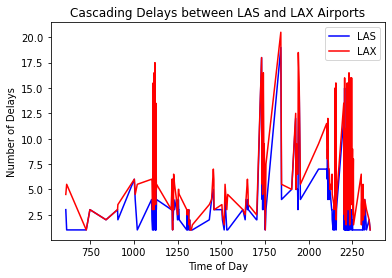

In [11]:
# plot delay trends for LAS and LAX airports
g = sns.lineplot(x="DepTime", y="delay_in_A", data=airport_A_B_A, color="blue")
g = sns.lineplot(x="DepTime", y="delay_in_B_and_C", data=airport_A_B_A, color="red")

# set axis labels and title
g.set(xlabel="Time of Day", ylabel="Number of Delays", title="Cascading Delays between LAS and LAX Airports")

# set color palette
sns.set_palette(["blue", "red"])

# show legend
plt.legend(labels=["LAS", "LAX"])

# show plot
plt.show()